In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 1
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

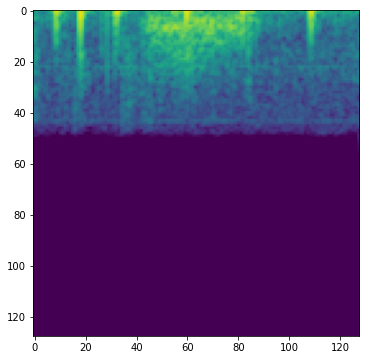

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet50

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
0.8457364500563139
TEST
loss: 0.7266654379784114
accuracy: 0.7587301587301587
******************
epoch: 1
Train
0.606320494763713
TEST
loss: 0.6409606655438741
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.5497233384038078
TEST
loss: 0.5906006655995808
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.5357014503717612
TEST
loss: 0.618631498965006
accuracy: 0.8126984126984127
******************
epoch: 4
Train
0.46767731315091643
TEST
loss: 0.5998536441061232
accuracy: 0.8285714285714286
******************
epoch: 5
Train
0.46510510893451307
TEST
loss: 0.7015353331490168
accuracy: 0.7015873015873015
******************
epoch: 6
Train
0.4040469568669559
TEST
loss: 1.929298524629502
accuracy: 0.3968253968253968
******************
epoch: 7
Train
0.40901834906520496
TEST
loss: 1.215480309440976
accuracy: 0.41904761904761906
******************
epoch: 8
Train
0.36434702801268853
TEST
loss: 0.5526433651409451
accuracy: 0.819047619047619
***********

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


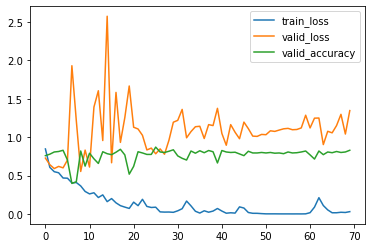

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8519507992163454
TEST
loss: 0.7837133231617156
accuracy: 0.765079365079365
******************
epoch: 1
Train
0.5905583567615537
TEST
loss: 0.602147016071138
accuracy: 0.8222222222222222
******************
epoch: 2
Train
0.5380937414949521
TEST
loss: 0.6146438784069486
accuracy: 0.7936507936507936
******************
epoch: 3
Train
0.4846571555111122
TEST
loss: 0.7763465086619059
accuracy: 0.780952380952381
******************
epoch: 4
Train
0.46212283624269546
TEST
loss: 0.6844899573023357
accuracy: 0.7714285714285715
******************
epoch: 5
Train
0.42199569486075683
TEST
loss: 6.559810161590576
accuracy: 0.273015873015873
******************
epoch: 6
Train
0.42059597844070057
TEST
loss: 1.5175166338209123
accuracy: 0.45714285714285713
******************
epoch: 7
Train
0.3982701105930391
TEST
loss: 0.6798335853077117
accuracy: 0.6857142857142857
******************
epoch: 8
Train
0.3059702973999231
TEST
loss: 0.6956631244175018
accuracy: 0.

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


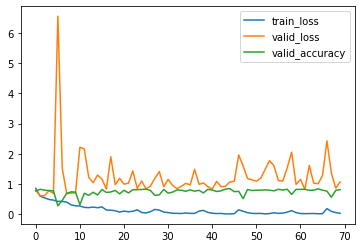

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8538209752869852
TEST
loss: 0.716365118632241
accuracy: 0.780952380952381
******************
epoch: 1
Train
0.6168728781844814
TEST
loss: 0.6772623561677479
accuracy: 0.7523809523809524
******************
epoch: 2
Train
0.5553014095668475
TEST
loss: 0.7589956688502478
accuracy: 0.7396825396825397
******************
epoch: 3
Train
0.567885017802168
TEST
loss: 0.5602153524519905
accuracy: 0.8158730158730159
******************
epoch: 4
Train
0.5363384520515172
TEST
loss: 0.6348827231497992
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.5114775634029728
TEST
loss: 1.027862725371406
accuracy: 0.5714285714285714
******************
epoch: 6
Train
0.5148319129294304
TEST
loss: 0.5543369966839987
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.41203441651356043
TEST
loss: 0.5883760308462476
accuracy: 0.8
******************
epoch: 8
Train
0.44123276213599727
TEST
loss: 0.6985684690021333
accuracy: 0.8095238095238095


In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


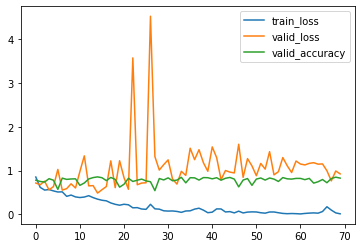

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8088333646961391
TEST
loss: 9.386622027745323
accuracy: 0.33015873015873015
******************
epoch: 1
Train
0.5878100588834883
TEST
loss: 0.6583301301986452
accuracy: 0.834920634920635
******************
epoch: 2
Train
0.5342851053446981
TEST
loss: 0.6384864451393248
accuracy: 0.746031746031746
******************
epoch: 3
Train
0.46391832842724584
TEST
loss: 0.5874384276450626
accuracy: 0.8126984126984127
******************
epoch: 4
Train
0.42120891582217834
TEST
loss: 0.47919032592622063
accuracy: 0.8444444444444444
******************
epoch: 5
Train
0.437577475812153
TEST
loss: 0.5804488638090709
accuracy: 0.8317460317460318
******************
epoch: 6
Train
0.4434711770631663
TEST
loss: 0.9119885039707971
accuracy: 0.8
******************
epoch: 7
Train
0.3199638024599804
TEST
loss: 0.5566575057922848
accuracy: 0.8285714285714286
******************
epoch: 8
Train
0.3149911010426316
TEST
loss: 1.0810754719234648
accuracy: 0.65714285714285

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


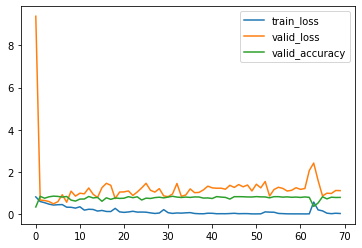

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8975249775067694
TEST
loss: 0.7045824363118126
accuracy: 0.819047619047619
******************
epoch: 1
Train
0.6106371041609239
TEST
loss: 1.221638548184955
accuracy: 0.6222222222222222
******************
epoch: 2
Train
0.5554043114942819
TEST
loss: 0.6584761490897527
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.547335249715802
TEST
loss: 0.5221400005476815
accuracy: 0.8222222222222222
******************
epoch: 4
Train
0.4423783557153676
TEST
loss: 0.6422615092898172
accuracy: 0.7777777777777778
******************
epoch: 5
Train
0.4386502866994965
TEST
loss: 0.6281511109972757
accuracy: 0.7746031746031746
******************
epoch: 6
Train
0.4129839233456385
TEST
loss: 0.5582801116837396
accuracy: 0.8095238095238095
******************
epoch: 7
Train
0.3942218364894722
TEST
loss: 1.0913025015876407
accuracy: 0.6984126984126984
******************
epoch: 8
Train
0.3416312632577773
TEST
loss: 1.307213942966764
accuracy: 0.806

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


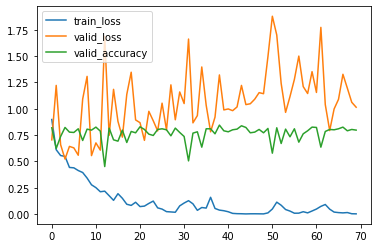

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8237754875369447
TEST
loss: 1.3209247710212828
accuracy: 0.8031746031746032
******************
epoch: 1
Train
0.7078130213962461
TEST
loss: 0.6227403674806867
accuracy: 0.7936507936507936
******************
epoch: 2
Train
0.6198188601930147
TEST
loss: 1.4260068144117082
accuracy: 0.4984126984126984
******************
epoch: 3
Train
0.6479061947065843
TEST
loss: 1.3926032668068296
accuracy: 0.6793650793650794
******************
epoch: 4
Train
0.5904370754412757
TEST
loss: 0.9134772887305608
accuracy: 0.819047619047619
******************
epoch: 5
Train
0.5616469048999244
TEST
loss: 0.5672845127090576
accuracy: 0.819047619047619
******************
epoch: 6
Train
0.5591618736600762
TEST
loss: 0.567512837856535
accuracy: 0.8095238095238095
******************
epoch: 7
Train
0.532936777502322
TEST
loss: 0.8995946903077383
accuracy: 0.6317460317460317
******************
epoch: 8
Train
0.5168372403543274
TEST
loss: 0.6046633807439653
accuracy: 0.815

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8629441624365483


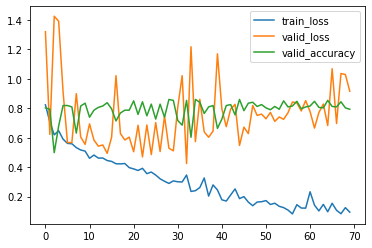

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0763331729329892
TEST
loss: 1.8009553239459084
accuracy: 0.30793650793650795
******************
epoch: 1
Train
0.7657325817915633
TEST
loss: 0.5875962094655113
accuracy: 0.7841269841269841
******************
epoch: 2
Train
0.6896580227127711
TEST
loss: 0.6173423290252685
accuracy: 0.7746031746031746
******************
epoch: 3
Train
0.6910231682021434
TEST
loss: 0.5388980350797139
accuracy: 0.8158730158730159
******************
epoch: 4
Train
0.6271094417553085
TEST
loss: 0.6252091562937176
accuracy: 0.8095238095238095
******************
epoch: 5
Train
0.6889234756646978
TEST
loss: 0.5390752415808421
accuracy: 0.834920634920635
******************
epoch: 6
Train
0.6811198847127207
TEST
loss: 0.5476421401614234
accuracy: 0.834920634920635
******************
epoch: 7
Train
0.637164403276845
TEST
loss: 0.5896155264642503
accuracy: 0.8412698412698413
******************
epoch: 8
Train
0.621407431539228
TEST
loss: 0.5844453870304047
accuracy: 0.8


In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


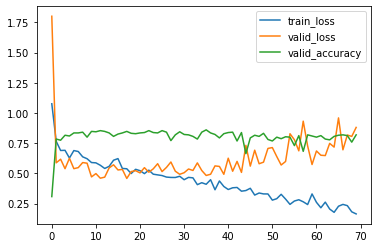

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9876279755184062
TEST
loss: 0.7770365035723126
accuracy: 0.7015873015873015
******************
epoch: 1
Train
0.728616837900342
TEST
loss: 0.6295767725460113
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.6899783071589148
TEST
loss: 0.8185048349319942
accuracy: 0.7365079365079366
******************
epoch: 3
Train
0.6712798411359476
TEST
loss: 0.5514270896003359
accuracy: 0.8285714285714286
******************
epoch: 4
Train
0.6031338933728061
TEST
loss: 0.7102409591750493
accuracy: 0.7238095238095238
******************
epoch: 5
Train
0.6003007549819158
TEST
loss: 9.550569734119234
accuracy: 0.31746031746031744
******************
epoch: 6
Train
0.5953232774050866
TEST
loss: 1.0073857837253146
accuracy: 0.7523809523809524
******************
epoch: 7
Train
0.5411563199176213
TEST
loss: 1.2010066092960419
accuracy: 0.45396825396825397
******************
epoch: 8
Train
0.4968430793787204
TEST
loss: 0.738051890759241
accuracy: 0.

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7969543147208121


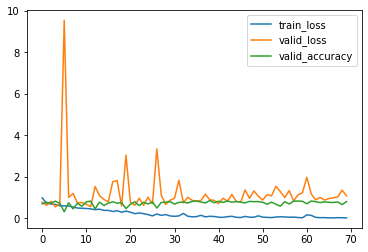

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8127580290753469
TEST
loss: 0.6811485886573792
accuracy: 0.7428571428571429
******************
epoch: 1
Train
0.6144575718094945
TEST
loss: 0.5403426336863685
accuracy: 0.8317460317460318
******************
epoch: 2
Train
0.5175026771660548
TEST
loss: 0.7238320187916831
accuracy: 0.692063492063492
******************
epoch: 3
Train
0.49938471753792313
TEST
loss: 0.5402394313660879
accuracy: 0.8476190476190476
******************
epoch: 4
Train
0.46202115249406545
TEST
loss: 0.8030834811074393
accuracy: 0.5777777777777777
******************
epoch: 5
Train
0.4840638994981222
TEST
loss: 0.5290683341404748
accuracy: 0.8412698412698413
******************
epoch: 6
Train
0.4437849021696495
TEST
loss: 0.9580239383001176
accuracy: 0.746031746031746
******************
epoch: 7
Train
0.38478994850036735
TEST
loss: 0.7829980029000176
accuracy: 0.7841269841269841
******************
epoch: 8
Train
0.3401929382959749
TEST
loss: 0.5812802450997488
accuracy: 

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


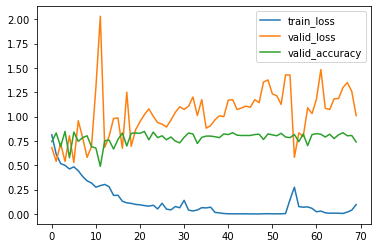

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8267157847110576
TEST
loss: 1.1350692737670172
accuracy: 0.6349206349206349
******************
epoch: 1
Train
0.5648130334682935
TEST
loss: 0.5437792908577692
accuracy: 0.8253968253968254
******************
epoch: 2
Train
0.5065172033427346
TEST
loss: 0.6325185196740287
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.5007611957687154
TEST
loss: 0.7712448048213172
accuracy: 0.7365079365079366
******************
epoch: 4
Train
0.4566211560304625
TEST
loss: 0.5988994517023601
accuracy: 0.8317460317460318
******************
epoch: 5
Train
0.44234546410649234
TEST
loss: 0.6515510634770469
accuracy: 0.7841269841269841
******************
epoch: 6
Train
0.4418629466587821
TEST
loss: 0.5928907280876523
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.4008020584407167
TEST
loss: 0.967972977956136
accuracy: 0.7714285714285715
******************
epoch: 8
Train
0.3212677531293501
TEST
loss: 0.6508645277174693
accuracy: 0

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7893401015228426


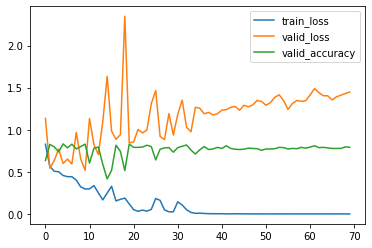

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8327839264233402
TEST
loss: 1.900671294378856
accuracy: 0.692063492063492
******************
epoch: 1
Train
0.6465546254414808
TEST
loss: 0.7577114069272601
accuracy: 0.6888888888888889
******************
epoch: 2
Train
0.5911323303642303
TEST
loss: 0.6653117775917053
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.5577609057555225
TEST
loss: 0.5508051104015774
accuracy: 0.819047619047619
******************
epoch: 4
Train
0.5114989466758073
TEST
loss: 0.6116291935481722
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.529861055640023
TEST
loss: 0.6833565895519559
accuracy: 0.8063492063492064
******************
epoch: 6
Train
0.5015004019447505
TEST
loss: 0.5037601453917367
accuracy: 0.8126984126984127
******************
epoch: 7
Train
0.48432107259111806
TEST
loss: 0.5089990513665336
accuracy: 0.819047619047619
******************
epoch: 8
Train
0.47469473244937477
TEST
loss: 0.7554556638475448
accuracy: 0.78

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8426395939086294


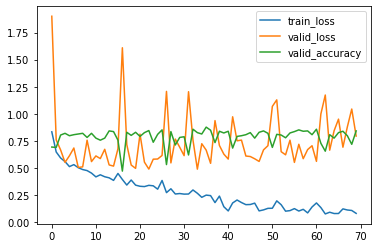

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0402082339272412
TEST
loss: 0.7480065351440793
accuracy: 0.7523809523809524
******************
epoch: 1
Train
0.7642911653655025
TEST
loss: 0.6147727408106365
accuracy: 0.7587301587301587
******************
epoch: 2
Train
0.696846601388301
TEST
loss: 0.5898547757239568
accuracy: 0.8
******************
epoch: 3
Train
0.6592052339844707
TEST
loss: 1.076702854746864
accuracy: 0.580952380952381
******************
epoch: 4
Train
0.6561246524262372
TEST
loss: 0.6333435132389977
accuracy: 0.7777777777777778
******************
epoch: 5
Train
0.6337435718942389
TEST
loss: 0.6913569319815863
accuracy: 0.8095238095238095
******************
epoch: 6
Train
0.6372758867344845
TEST
loss: 0.6753499089725434
accuracy: 0.746031746031746
******************
epoch: 7
Train
0.6234039032241482
TEST
loss: 1.0502060076547048
accuracy: 0.6571428571428571
******************
epoch: 8
Train
0.5933243225168102
TEST
loss: 0.5582632744123065
accuracy: 0.8253968253968254
*

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


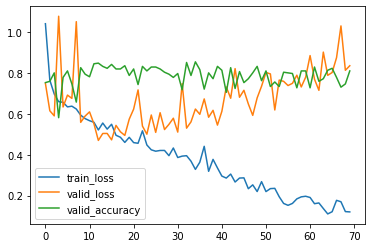

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8867217521993199
TEST
loss: 6.8554029222518675
accuracy: 0.32063492063492066
******************
epoch: 1
Train
0.7186660857973258
TEST
loss: 1.1467455182756696
accuracy: 0.6507936507936508
******************
epoch: 2
Train
0.6327579165376114
TEST
loss: 0.5913595422865853
accuracy: 0.8158730158730159
******************
epoch: 3
Train
0.6118803817758113
TEST
loss: 0.55894264531514
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.538407066495197
TEST
loss: 0.6192441223159669
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.5594129730918466
TEST
loss: 0.49711200888194734
accuracy: 0.834920634920635
******************
epoch: 6
Train
0.5023981867042963
TEST
loss: 0.7684423325553773
accuracy: 0.7777777777777778
******************
epoch: 7
Train
0.5085368881252098
TEST
loss: 0.5058203470139276
accuracy: 0.8507936507936508
******************
epoch: 8
Train
0.5349287287028087
TEST
loss: 0.8776698513636514
accuracy: 0.7

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8451776649746193


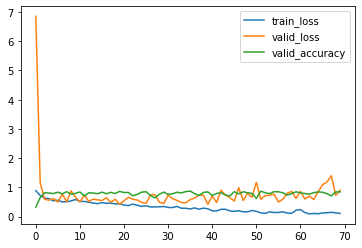

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
1.0109408702804892
TEST
loss: 0.6431241169808403
accuracy: 0.780952380952381
******************
epoch: 1
Train
0.7303709046910735
TEST
loss: 0.5895134127329267
accuracy: 0.7714285714285715
******************
epoch: 2
Train
0.6713149927503254
TEST
loss: 1.1057145788556053
accuracy: 0.7015873015873015
******************
epoch: 3
Train
0.6549117608237021
TEST
loss: 0.5789413571357727
accuracy: 0.8158730158730159
******************
epoch: 4
Train
0.6335843893343537
TEST
loss: 0.6681494654171051
accuracy: 0.7619047619047619
******************
epoch: 5
Train
0.647127376841211
TEST
loss: 0.4521366562162127
accuracy: 0.8507936507936508
******************
epoch: 6
Train
0.5817296639664766
TEST
loss: 0.883012885139102
accuracy: 0.6761904761904762
******************
epoch: 7
Train
0.5916304880423239
TEST
loss: 0.5026572978685773
accuracy: 0.8507936507936508
******************
epoch: 8
Train
0.5769681318398976
TEST
loss: 0.5855409934407189
accuracy: 0.83

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8299492385786802


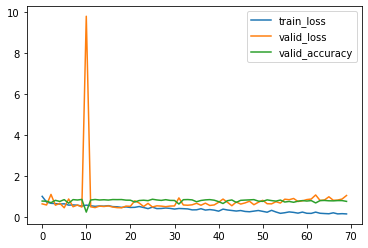

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8061758008999328
TEST
loss: 8.94940808614095
accuracy: 0.2761904761904762
******************
epoch: 1
Train
0.5783248698787143
TEST
loss: 0.5857048573948088
accuracy: 0.7587301587301587
******************
epoch: 2
Train
0.5632148661056713
TEST
loss: 0.9959814465235151
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.5205862646163504
TEST
loss: 0.5477556152949258
accuracy: 0.8317460317460318
******************
epoch: 4
Train
0.4543958587529074
TEST
loss: 1.3334577596376813
accuracy: 0.5396825396825397
******************
epoch: 5
Train
0.4516753337987365
TEST
loss: 0.5159099189061968
accuracy: 0.8126984126984127
******************
epoch: 6
Train
0.41460358812470016
TEST
loss: 0.9264569239010887
accuracy: 0.5873015873015873
******************
epoch: 7
Train
0.37897576811864697
TEST
loss: 0.5378732302832225
accuracy: 0.8063492063492064
******************
epoch: 8
Train
0.3557556867126059
TEST
loss: 0.7982201262125893
accuracy: 0

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


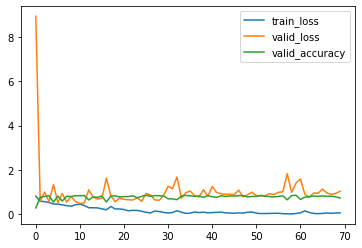

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8305100484250366
TEST
loss: 0.6798821922332522
accuracy: 0.8
******************
epoch: 1
Train
0.6229077132804892
TEST
loss: 0.6024567149934315
accuracy: 0.8
******************
epoch: 2
Train
0.5398537856278862
TEST
loss: 0.5352817136143881
accuracy: 0.834920634920635
******************
epoch: 3
Train
0.5222053216316096
TEST
loss: 0.7913981278737386
accuracy: 0.6095238095238096
******************
epoch: 4
Train
0.5073318992274635
TEST
loss: 0.48042040268580116
accuracy: 0.8412698412698413
******************
epoch: 5
Train
0.4841792503929593
TEST
loss: 0.49261020365215485
accuracy: 0.8476190476190476
******************
epoch: 6
Train
0.5103982530291635
TEST
loss: 1.1409117066670977
accuracy: 0.6095238095238096
******************
epoch: 7
Train
0.4761746090920413
TEST
loss: 0.4925552845001221
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.4249459411342339
TEST
loss: 0.576645397004627
accuracy: 0.8285714285714286
************

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


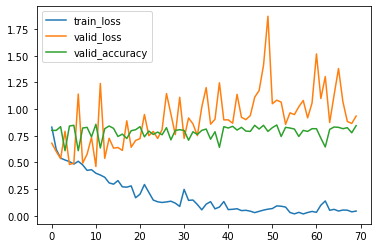

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.9466885771421898
TEST
loss: 2.4476262319655646
accuracy: 0.26031746031746034
******************
epoch: 1
Train
0.6459333206141534
TEST
loss: 0.604893459970989
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.5504266275973241
TEST
loss: 0.5633260151696584
accuracy: 0.819047619047619
******************
epoch: 3
Train
0.49936692022538737
TEST
loss: 0.4722337972550165
accuracy: 0.8380952380952381
******************
epoch: 4
Train
0.4511689265348118
TEST
loss: 1.5343034365820507
accuracy: 0.707936507936508
******************
epoch: 5
Train
0.4611464521068728
TEST
loss: 0.6269290127451458
accuracy: 0.7333333333333333
******************
epoch: 6
Train
0.4264936597693809
TEST
loss: 1.0004963360135517
accuracy: 0.6444444444444445
******************
epoch: 7
Train
0.41181145029658833
TEST
loss: 0.9906330574126471
accuracy: 0.638095238095238
******************
epoch: 8
Train
0.37016699302755146
TEST
loss: 0.9905555344763256
accuracy: 0

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7918781725888325


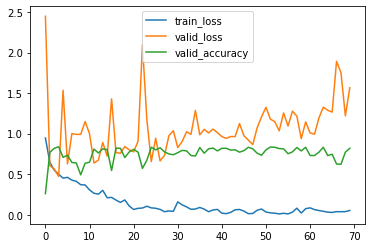

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.7782749670947516
TEST
loss: 0.7735500706566705
accuracy: 0.8
******************
epoch: 1
Train
0.5909674034362942
TEST
loss: 1.7711181042686341
accuracy: 0.5333333333333333
******************
epoch: 2
Train
0.5244976532800127
TEST
loss: 0.6383480851612394
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.47264334022099297
TEST
loss: 0.8826211183790177
accuracy: 0.7523809523809524
******************
epoch: 4
Train
0.43012472416693676
TEST
loss: 0.7293579423238361
accuracy: 0.726984126984127
******************
epoch: 5
Train
0.4600068570319578
TEST
loss: 1.2359976128926353
accuracy: 0.5142857142857142
******************
epoch: 6
Train
0.4009296119189433
TEST
loss: 1.0016624859401158
accuracy: 0.6793650793650794
******************
epoch: 7
Train
0.40053347006404655
TEST
loss: 0.5426933784333486
accuracy: 0.7904761904761904
******************
epoch: 8
Train
0.31445274386640765
TEST
loss: 0.79869659817408
accuracy: 0.7809523809523

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8020304568527918


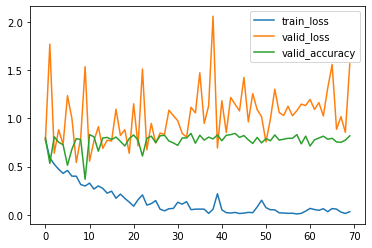

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.8459724725665698
TEST
loss: 4.015514427518088
accuracy: 0.638095238095238
******************
epoch: 1
Train
0.6968124930445783
TEST
loss: 0.6330044805057465
accuracy: 0.8126984126984127
******************
epoch: 2
Train
0.5980886997828131
TEST
loss: 0.8734581848931691
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.7084971335409557
TEST
loss: 0.5608760292567904
accuracy: 0.7936507936507936
******************
epoch: 4
Train
0.589134637328535
TEST
loss: 0.7998518432889666
accuracy: 0.7904761904761904
******************
epoch: 5
Train
0.5199638487707536
TEST
loss: 0.7379469031379337
accuracy: 0.692063492063492
******************
epoch: 6
Train
0.4863980206423472
TEST
loss: 0.4829263197051154
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.47934695687721984
TEST
loss: 0.5059120335276165
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.4533154638728232
TEST
loss: 0.5863928128802587
accuracy: 0.82

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7918781725888325


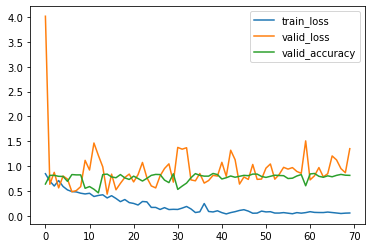

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 1
epoch: 0
Train
0.985763883287704
TEST
loss: 0.787300886048211
accuracy: 0.6698412698412698
******************
epoch: 1
Train
0.7632640571325331
TEST
loss: 0.9780656354767936
accuracy: 0.6888888888888889
******************
epoch: 2
Train
0.6064992338726689
TEST
loss: 0.558339748496101
accuracy: 0.8031746031746032
******************
epoch: 3
Train
0.5723666935046577
TEST
loss: 0.807847199364314
accuracy: 0.7746031746031746
******************
epoch: 4
Train
0.5271704638875412
TEST
loss: 0.5684087724912734
accuracy: 0.8
******************
epoch: 5
Train
0.5901877236233712
TEST
loss: 1.024437683536893
accuracy: 0.5301587301587302
******************
epoch: 6
Train
0.5167998487368001
TEST
loss: 0.678981496038891
accuracy: 0.7365079365079366
******************
epoch: 7
Train
0.4597312559486856
TEST
loss: 0.7600139928242516
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.4890919311639333
TEST
loss: 0.8082604650467161
accuracy: 0.8158730158730159
***

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.817258883248731


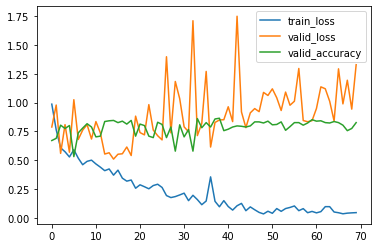

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()